In [11]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import hilbert, chirp

# load dataset and show the first run
case1run1 = pd.read_csv('./mill_data/case1run1.csv')
case1run2 = pd.read_csv('./mill_data/case1run2.csv')
columns=['case', 'run', 'VB', 'time', 'doc','feed','material','smcAC', 'smcDC', 'vib_table', 'vib_spindle', 'AE_table', 'AE_spindle']
case1run1.columns = columns
case1run2.columns = columns

In [12]:
import pandas as pd
import numpy as np
import dask.dataframe as dd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing, metrics
from ipywidgets import widgets, interactive
import gc
import joblib
import glob
import os
import warnings
from datetime import datetime, timedelta
from typing import Union
from tqdm.notebook import tqdm_notebook as tqdm
from itertools import cycle
import datetime as dt
from torch.autograd import Variable
import random
from matplotlib.pyplot import figure
import torch
import torch.nn as nn
from copy import deepcopy
from torch.utils.data import Dataset
from sklearn.metrics import mean_squared_error



warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

from lstm_attention import lstmattention

In [13]:
def sliding_windows(data, seq_length):
    x = []
    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        x.append(_x)

    return np.array(x)

In [ ]:
tmp = []
for i, j in enumerate(c1_y):    
    if i==(len(c1_y)-1):        
        break    
    if j != c1_y[i+1]:        
        tmp.append(i+1)
    for i,j in enumerate(tmp):    
        if i == 0:        
            nterval=c1_y_[j]/(j-1)        
    for ii in range(j):            
        if ii != (j-1):                
            c1_y_[0+ii+1]=0+interval*ii    
        else:       
            interval=(c1_y_[tmp[i]]-c1_y_[tmp[i-1]])/(tmp[i]-tmp[i-1]-1)      
    # print(interval)       
     for ii in range(tmp[i-1], tmp[i]):            
        if ii != (tmp[i]-1):              
            c1_y_[ii+1]=c1_y_[tmp[i-1]]+interval*(ii-tmp[i-1]+1)

In [14]:
def labeling(data,seq_length,lab):
    x = []
    for i in range(len(data)-seq_length-1):
        x.append(lab)

    return np.array(x)

In [16]:
path1 = './mill_data/train/'
path2 = './mill_data/test/'

file_list1 = os.listdir(path1)
file_list2 = os.listdir(path2)

In [71]:
case1run1 = pd.read_csv(path1+file_list1[0])
# case1run2 = pd.read_csv('./mill_data/case1run2.csv')
columns=['case', 'run', 'VB', 'time', 'doc','feed','material','smcAC', 'smcDC', 'vib_table', 'vib_spindle', 'AE_table', 'AE_spindle']
case1run1.columns = columns
# case1run2.columns = columns

In [80]:
fs = 100000
def hibert_transform(data):
    analytic_signal = hilbert(data)
    amplitude_envelope = np.abs(analytic_signal)
    instantaneous_phase = np.unwrap(np.angle(analytic_signal))
    instantaneous_frequency = (np.diff(instantaneous_phase) /(2.0*np.pi) * fs)
    return amplitude_envelope,instantaneous_phase

In [8]:
def to_dataset(data,label):
    smcAC=np.expand_dims(sliding_windows(data['smcAC'][3000:-3000],4),axis=2)
    evelop,ins_freq=hibert_transform(data['smcAC'][3000:-3000])
    evelop_d=np.expand_dims(sliding_windows(evelop,4),axis=2)
    ins_freq_d=np.expand_dims(sliding_windows(ins_freq,4),axis=2)

    # smcDC=np.expand_dims(sliding_windows(data['smcDC'][3000:-3000],4),axis=2)
    vib_table=np.expand_dims(sliding_windows(data['vib_table'][3000:-3000],4),axis=2)
    vib_spindle=np.expand_dims(sliding_windows(data['vib_spindle'][3000:-3000],4),axis=2)
    AE_table=np.expand_dims(sliding_windows(data['AE_table'][3000:-3000],4),axis=2)
    AE_spindle=np.expand_dims(sliding_windows(data['AE_spindle'][3000:-3000],4),axis=2)
    xdata = np.concatenate((smcAC,vib_table,vib_spindle,AE_table,AE_spindle,evelop_d,ins_freq_d),axis=2)
    ydata = labeling(data[3000:-3000],4, label)

    return xdata,ydata

In [21]:
def to_casedataset_tr(data_list):
    empty_x=np.zeros(((1, 4, 7)))
    empty_y=np.zeros(((1)))

    for i in data_list:
        pdd=pd.read_csv('./mill_data/test/'+i)
        pdd.columns = columns
        lab=pdd['VB'][0]
        if str(lab)!='nan':
            x_,y_=to_dataset(pdd,lab)
            empty_x=np.concatenate((empty_x,x_),axis=0)
            empty_y=np.concatenate((empty_y,y_),axis=0)
    
    return empty_x[1:],empty_y[1:]

In [22]:
def to_casedataset_ts(data_list):
    empty_x=np.zeros(((1, 4, 7)))
    empty_y=np.zeros(((1)))

    for i in data_list:
        pdd=pd.read_csv('./mill_data/train/'+i)
        pdd.columns = columns
        lab=pdd['VB'][0]
        if str(lab)!='nan':
            x_,y_=to_dataset(pdd,lab)
            empty_x=np.concatenate((empty_x,x_),axis=0)
            empty_y=np.concatenate((empty_y,y_),axis=0)
    
    return empty_x[1:],empty_y[1:]

In [23]:
case1list=[file for file in file_list2 if file.startswith('case')]
case9list=[file for file in file_list1 if file.startswith('case1')]
case2list=[file for file in file_list1 if file.startswith('case2')]
case3list=[file for file in file_list1 if file.startswith('case3')]
case4list=[file for file in file_list1 if file.startswith('case4')]

In [25]:
c1_x,c1_y=to_casedataset_tr(case1list)

In [26]:
c9_x,c9_y=to_casedataset_ts(case9list)

In [27]:
c10_x,c10_y=to_casedataset_ts(case2list)
c11_x,c11_y=to_casedataset_ts(case3list)
c12_x,c12_y=to_casedataset_ts(case4list)


In [29]:
class SequenceDataset(Dataset):
    def __init__(self, x, y):
        self.x=x
        self.y=y
        
    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, i): 
        data=self.x[i]
        label=self.y[i]

        return data,label

In [30]:
c1_x = Variable(torch.Tensor(np.array(c1_x)))
c1_y = Variable(torch.Tensor(np.array(c1_y)))
c9_x = Variable(torch.Tensor(np.array(c9_x)))
c9_y = Variable(torch.Tensor(np.array(c9_y)))


print("train shape is:",c1_x.size())
print("train label shape is:",c1_y.size())
print("test shape is:",c9_x.size())
print("test label shape is:",c9_y.size())

train shape is: torch.Size([116766, 4, 7])
train label shape is: torch.Size([116766])
test shape is: torch.Size([38922, 4, 7])
test label shape is: torch.Size([38922])


In [31]:
c10_x = Variable(torch.Tensor(np.array(c10_x)))
c10_y = Variable(torch.Tensor(np.array(c10_y)))
c11_x = Variable(torch.Tensor(np.array(c11_x)))
c11_y = Variable(torch.Tensor(np.array(c11_y)))
c12_x = Variable(torch.Tensor(np.array(c12_x)))
c12_y = Variable(torch.Tensor(np.array(c12_y)))
c10_dataset=SequenceDataset(c10_x,c10_y)
c11_dataset=SequenceDataset(c11_x,c11_y)
c12_dataset=SequenceDataset(c12_x,c12_y)

In [32]:
c1_dataset=SequenceDataset(c1_x,c1_y)
c9_dataset=SequenceDataset(c9_x,c9_y)

In [33]:
torch.manual_seed(99)

train_loader = DataLoader(c1_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(c9_dataset, batch_size=1, shuffle=False)


In [42]:
learning_rate = 1e-3
num_hidden_units = 8
epochs = 30
model = ShallowRegressionLSTM(num_sensors=7, hidden_units=num_hidden_units)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [43]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=10, threshold_mode='abs',min_lr=1e-8, verbose=True)


In [44]:
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()

    for X, y in data_loader:
        output = model(X)
        loss = torch.sqrt(loss_function(output, y))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    

    avg_loss = total_loss / num_batches
    return avg_loss

def test_model(data_loader, model, loss_function):

    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            total_loss += torch.sqrt(loss_function(output, y)).item()

    avg_loss = total_loss / num_batches
    return avg_loss

In [45]:

print("Untrained test")
print(test_model(test_loader, model, loss_function))
best_fitness = -100000


Untrained test
0.17317828939975236


run: 0
train_loss: 0.128476640254986
test_loss: 0.09617313929409421
run: 1
train_loss: 0.08891938720281302
test_loss: 0.09847003681885057
run: 2
train_loss: 0.08426898262453557
test_loss: 0.08559633304886752
run: 3
train_loss: 0.08261446135869481
test_loss: 0.08575200755642041
run: 4
train_loss: 0.08121652519251261
test_loss: 0.09281086473990906
run: 5
train_loss: 0.08061045251131287
test_loss: 0.06431455476593612
run: 6
train_loss: 0.08011509313624048
test_loss: 0.06619313633455401
Epoch 00014: reducing learning rate of group 0 to 5.0000e-04.
run: 7
train_loss: 0.07656725370992566
test_loss: 0.07142698183141959
run: 8
train_loss: 0.075950144363629
test_loss: 0.07559305201703087
run: 9
train_loss: 0.07430864341309966
test_loss: 0.08113056406061749
run: 10
train_loss: 0.07186168702061485
test_loss: 0.0811308419204516
run: 11
train_loss: 0.06979383081483592
test_loss: 0.08125590458095003
run: 12
train_loss: 0.06917970880935473
test_loss: 0.06413464262211722
Epoch 00025: reducing learning

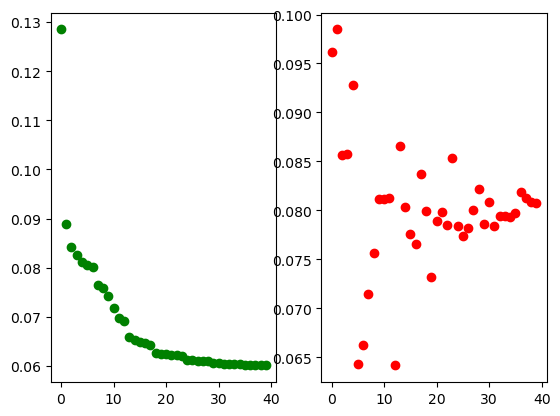

In [46]:
fig, axs = plt.subplots(1, 2)
for epoch in range(40):
    print("run:", epoch)
    train_loss = train_model(train_loader, model, loss_function, optimizer=optimizer)
    test_loss = test_model(test_loader, model, loss_function)
    print("train_loss:",train_loss)
    print("test_loss:",test_loss)
    axs[0].scatter(epoch, train_loss, color='g')
    axs[1].scatter(epoch, test_loss, color='r')
    fitness = -test_loss
    scheduler.step(test_loss)

    if fitness > best_fitness:
        best_fitness = fitness
        best_model = deepcopy(model)

    scheduler.step(test_loss)

In [48]:
def test_model2(data_loader, model, loss_function):

    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    a=[]
    b=[]
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            total_loss += torch.sqrt(loss_function(output, y)).item()
            a.append(y.detach().cpu())
            b.append(output.detach().cpu())

    avg_loss = total_loss / num_batches
    return avg_loss,a,b

In [50]:
test_loader = DataLoader(c9_dataset, batch_size=int(len(c9_dataset)/13), shuffle=False)
print('Predictions on test set')

Predictions on test set


In [51]:
c,v,n=test_model2(test_loader, model, loss_function)

In [52]:
q,w=[],[]
for i in range(len(v)):
    q.append(sum(v[i])/len(v[i]))
    w.append(sum(n[i])/len(n[i]))

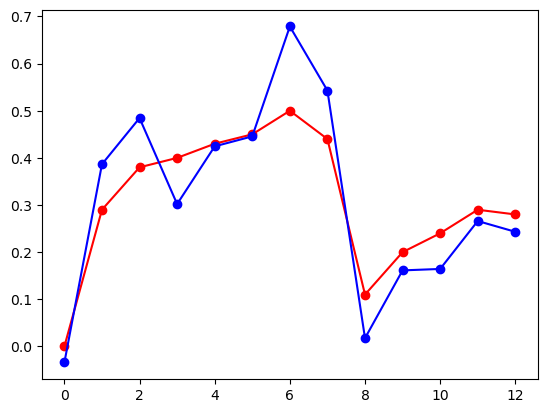

In [54]:
plt.plot(q, 'bo-',color='r')
plt.plot(w, 'bo-',color='b')

In [55]:
test_loader = DataLoader(c9_dataset, batch_size=int(len(c9_dataset)/13), shuffle=False)
print('Predictions on test set')

Predictions on test set


In [56]:
c,v,n=test_model2(test_loader, model, loss_function)

In [57]:
c,v,n=test_model2(test_loader, model, loss_function)

In [58]:
q,w=[],[]
for i in range(len(v)):
    q.append(sum(v[i])/len(v[i]))
    w.append(sum(n[i])/len(n[i]))

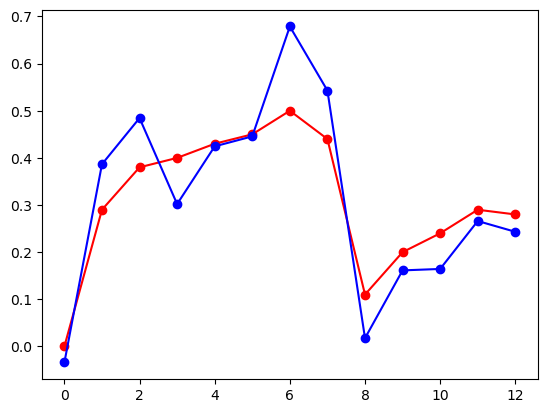

In [59]:
plt.plot(q, 'bo-',color='r')
plt.plot(w, 'bo-',color='b')

In [60]:
c10_x = Variable(torch.Tensor(np.array(c10_x)))
c10_y = Variable(torch.Tensor(np.array(c10_y)))
c11_x = Variable(torch.Tensor(np.array(c11_x)))
c11_y = Variable(torch.Tensor(np.array(c11_y)))
c12_x = Variable(torch.Tensor(np.array(c12_x)))
c12_y = Variable(torch.Tensor(np.array(c12_y)))
c10_dataset=SequenceDataset(c10_x,c10_y)
c11_dataset=SequenceDataset(c11_x,c11_y)
c12_dataset=SequenceDataset(c12_x,c12_y)

Predictions on test set


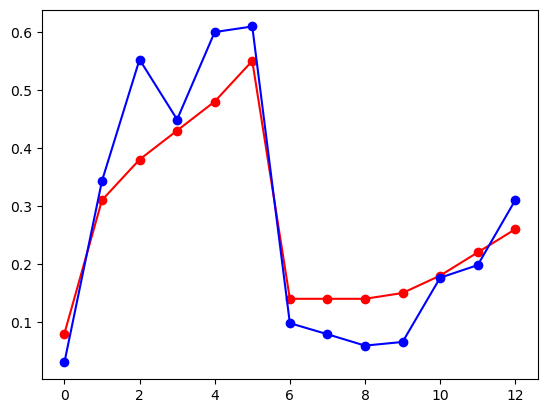

In [67]:
test_loader = DataLoader(c10_dataset, batch_size=int(len(c10_dataset)/13), shuffle=False)
print('Predictions on test set')

c,v,n=test_model2(test_loader, model, loss_function)

q,w=[],[]
for i in range(len(v)):
    q.append(sum(v[i])/len(v[i]))
    w.append(sum(n[i])/len(n[i]))
    
plt.plot(q, 'bo-',color='r')
plt.plot(w, 'bo-',color='b')

Predictions on test set


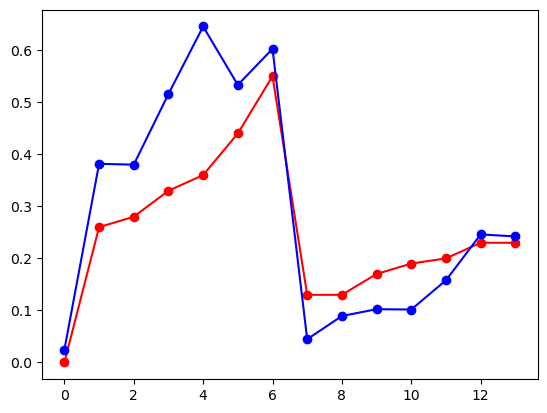

In [68]:
test_loader = DataLoader(c11_dataset, batch_size=int(len(c11_dataset)/14), shuffle=False)
print('Predictions on test set')

c,v,n=test_model2(test_loader, model, loss_function)

q,w=[],[]
for i in range(len(v)):
    q.append(sum(v[i])/len(v[i]))
    w.append(sum(n[i])/len(n[i]))
    
plt.plot(q, 'bo-',color='r')
plt.plot(w, 'bo-',color='b')

Predictions on test set


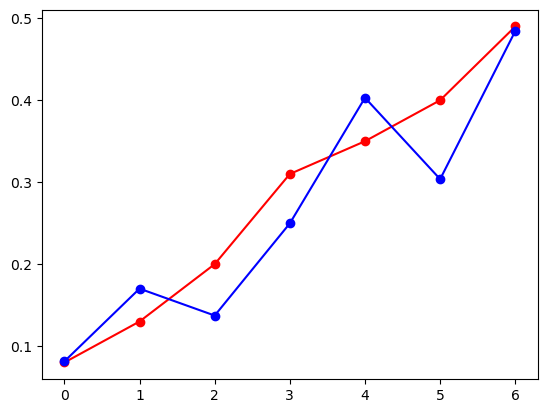

In [63]:
test_loader = DataLoader(c12_dataset, batch_size=int(len(c12_dataset)/7), shuffle=False)
print('Predictions on test set')

c,v,n=test_model2(test_loader, model, loss_function)

q,w=[],[]
for i in range(len(v)):
    q.append(sum(v[i])/len(v[i]))
    w.append(sum(n[i])/len(n[i]))
    
plt.plot(q, 'bo-',color='r')
plt.plot(w, 'bo-',color='b')